# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## DONE ##
train_transforms = transforms.Compose([transforms.RandomRotation(35),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Create training set and define training dataloader
## DONE ##
train_set = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = train_transforms)


# Creating a validation-set out of the training set for validation:
# Out of the Udacity Course 'Intro to deep learning with pytorch

## Percentage of trainset which is used for validation during training
n_valid = 0.1

## Dividing the trainset to a training and validation set 
n_train = len(train_set)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

## Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
trainloader = torch.utils.data.DataLoader(train_set, sampler = train_sampler, batch_size = 64)

valid_sampler = SubsetRandomSampler(valid_idx)
validloader = torch.utils.data.DataLoader(train_set, sampler = valid_sampler, batch_size = 64)


# Create test set and define test dataloader
## DONE ##
test_set = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = test_transforms)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 64)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


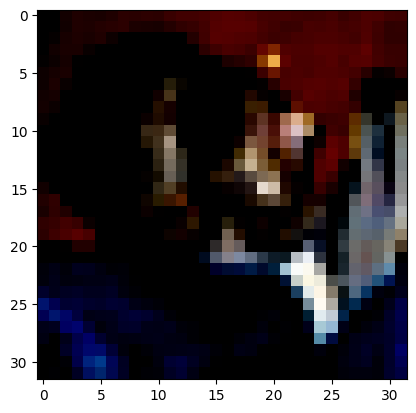

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


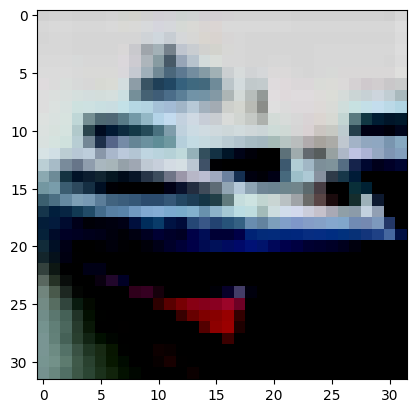

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


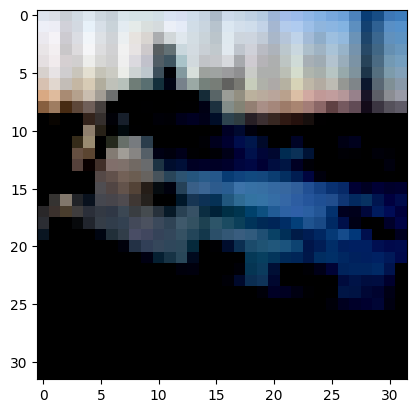

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


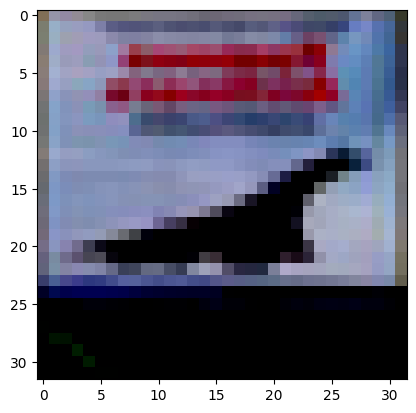

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


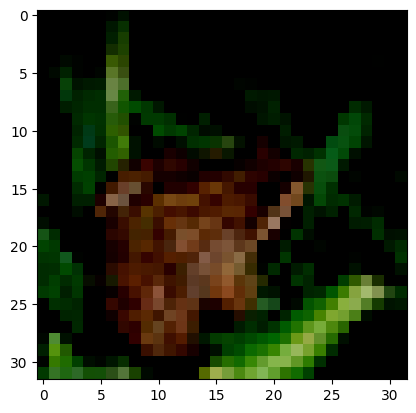

Features Size: torch.Size([64, 3, 32, 32])
Labels Size: torch.Size([64])
Number of images in trainset: 45000
Number of images in validationset: 5000
Number of images in testset: 10000


In [4]:
# Explore data
## YOUR CODE HERE ##
show5(testloader)
features, labels = next(iter(trainloader))
print(f'Features Size: {features.size()}')
print(f'Labels Size: {labels.size()}')
print(f'Number of images in trainset: {len(train_sampler)}')
print(f'Number of images in validationset: {len(valid_sampler)}')
print(f'Number of images in testset: {len(test_set)}')
#size, how many collor channels, how many images in test and trainset

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
## DONE ##
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# Reference: Udacity Lesson https://learn.udacity.com/courses/ud188/lessons/7f6284d3-6c52-49a3-9a10-602f015918af/concepts/3945d6e8-8952-4b8d-b853-e8a7abd545e2?_gl=1*1bw8rug*_gcl_au*MTEzODc5MTcwMC4xNzMyNjI0MTEw*_ga*MTk3MzQyNTEwOS4xNzI0ODI4Mjcw*_ga_CF22GKVCFK*MTczMjc3OTQxNC44NS4xLjE3MzI3Nzk0MTkuNTUuMC4w&lesson_tab=lesson

class image_net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Building convolutional layer
        # (input channels, out_channels, kernel, padding)
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        # Building a maxpooling layer
        # (kernel_size, stride_size)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Building fully connected layer for classification including a dropout
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p = 0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x
        
cifar_net = image_net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
## DONE ##

#Defining the loss function (Negative Log Likelyhood loss) - used before.
criterion = nn.NLLLoss()

#Defining the optimizer
optimizer = optim.Adam(cifar_net.parameters(), lr = 0.001)

#Setting the device, where the training takes place - GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
## DONE ##
#Setting the epochs for the training
epochs = 30
trained_epochs = 0
#running_loss is the counter for the loss in every training batch
running_loss = 0 
#steps counts the number of batches trained (64 images per batch)
steps = 0 
#Output of validation testing during the training
print_every = 200

#Loading the network to device
cifar_net.to(device)

#preparing data for the plot
accuracies, training_losses, validation_losses = [], [], []

# Training starts here:

for e in range(epochs):
    """Epochs"""
    
    for images, labels in trainloader:
        """using the training dataset for training"""
        
        #increasing step per batch of 64 images
        steps +=1
        
        #moving images- and labels-tensor to device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        #Training of the network with the given images
        optimizer.zero_grad()
        log_ps = cifar_net.forward(images) #forward pass
        loss = criterion(log_ps, labels) #calculating the loss
        loss.backward() #backpropagation
        optimizer.step() #updating the weights and biases
        
        #adding the loss to running_loss to get an average loss per print_every
        running_loss += loss.item()

        
        if steps % print_every == 0:
            """After print_every batches a validation is made- with Train-, Validation-Loss und Validation-Accuracy"""
            
            validation_loss = 0
            validation_accuracy = 0
            
            #setting the model to evaluation mode without dropout
            cifar_net.eval()
            
            with torch.no_grad():
                """running the model without autograd-engine to be faster in validation
                    - no backpropagation needed"""
                
                for images, labels in validloader:
                    """using the validloader for the validation set"""
                    
                    #moving the images- and labels-tensor to device (GPU or CPU)
                    images, labels = images.to(device), labels.to(device)
                    
                    #validate the validation-images through the model and calculating the loss.
                    log_ps = cifar_net.forward(images)
                    batch_loss = criterion(log_ps, labels)
                    
                    #adding the batch_loss to validation loss
                    validation_loss += batch_loss.item()
                    
                    #calculating the accuracy
                    probability = torch.exp(log_ps)
                    top_p, top_class = probability.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    validation_accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                print(f"Epochs: {e + 1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Validation loss: {validation_loss/len(validloader):.3f}.. "
                    f"Validation accuracy: {100*validation_accuracy/len(validloader):.2f}%")
                
                # appending the accurcy and losses for the plot
                accuracies.append(validation_accuracy/len(validloader))
                training_losses.append(running_loss/ print_every)
                validation_losses.append(validation_loss/ len(validloader))
                
                # setting back the running_loss
                running_loss = 0
                
                #break # for testing on CPU if the code runs without bugs.
                
            # setting the model back to training mode with given dropout
            cifar_net.train()
            
    #break # for testing on CPU if the code runs without bugs
    
trained_epochs += e+1
print(f"Trained epochs: {trained_epochs}")

Epochs: 1/30.. Train loss: 2.001.. Validation loss: 1.774.. Validation accuracy: 31.70%
Epochs: 1/30.. Train loss: 1.671.. Validation loss: 1.569.. Validation accuracy: 41.93%
Epochs: 1/30.. Train loss: 1.540.. Validation loss: 1.414.. Validation accuracy: 48.26%
Epochs: 2/30.. Train loss: 1.458.. Validation loss: 1.386.. Validation accuracy: 49.35%
Epochs: 2/30.. Train loss: 1.367.. Validation loss: 1.313.. Validation accuracy: 51.82%
Epochs: 2/30.. Train loss: 1.341.. Validation loss: 1.255.. Validation accuracy: 54.00%
Epochs: 2/30.. Train loss: 1.295.. Validation loss: 1.261.. Validation accuracy: 54.33%
Epochs: 3/30.. Train loss: 1.260.. Validation loss: 1.179.. Validation accuracy: 57.71%
Epochs: 3/30.. Train loss: 1.229.. Validation loss: 1.169.. Validation accuracy: 57.93%
Epochs: 3/30.. Train loss: 1.211.. Validation loss: 1.147.. Validation accuracy: 59.12%
Epochs: 4/30.. Train loss: 1.168.. Validation loss: 1.168.. Validation accuracy: 58.43%
Epochs: 4/30.. Train loss: 1.144

Epochs: 27/30.. Train loss: 0.734.. Validation loss: 0.753.. Validation accuracy: 74.17%
Epochs: 27/30.. Train loss: 0.700.. Validation loss: 0.750.. Validation accuracy: 73.99%
Epochs: 28/30.. Train loss: 0.699.. Validation loss: 0.762.. Validation accuracy: 73.89%
Epochs: 28/30.. Train loss: 0.694.. Validation loss: 0.745.. Validation accuracy: 74.70%
Epochs: 28/30.. Train loss: 0.700.. Validation loss: 0.772.. Validation accuracy: 73.46%
Epochs: 29/30.. Train loss: 0.689.. Validation loss: 0.765.. Validation accuracy: 73.67%
Epochs: 29/30.. Train loss: 0.709.. Validation loss: 0.824.. Validation accuracy: 71.68%
Epochs: 29/30.. Train loss: 0.706.. Validation loss: 0.753.. Validation accuracy: 74.92%
Epochs: 29/30.. Train loss: 0.697.. Validation loss: 0.753.. Validation accuracy: 73.99%
Epochs: 30/30.. Train loss: 0.695.. Validation loss: 0.756.. Validation accuracy: 74.39%
Epochs: 30/30.. Train loss: 0.676.. Validation loss: 0.762.. Validation accuracy: 73.40%
Epochs: 30/30.. Train

Plot the training loss (and validation loss/accuracy, if recorded).

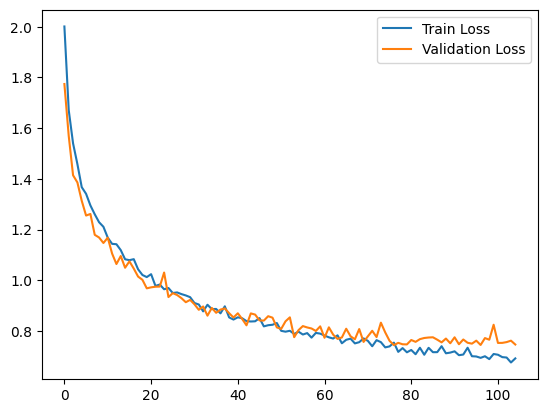

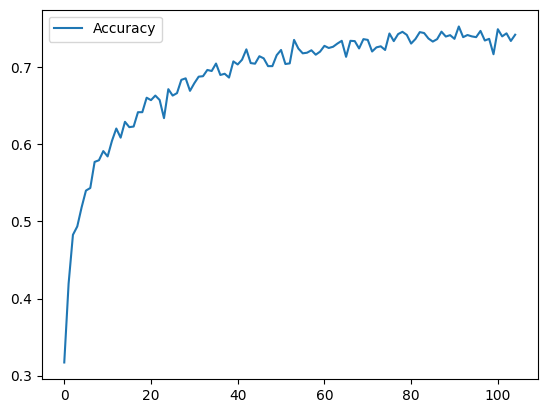

In [12]:
## DONE ##
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

plt.plot(training_losses, label = 'Train Loss')
plt.plot(validation_losses, label = 'Validation Loss')
plt.legend()
plt.show()

plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
## DONE ##

#setting the model to evaluation mode without dropout
cifar_net.eval()

test_loss = 0
test_accuracy = 0

with torch.no_grad():
    """running the model without autograd-engine to be faster in validation
        - no backpropagation needed"""
                
    for images, labels in testloader:
        """using the testloader for the test-set"""
                    
        #moving the images- and labels-tensor to device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
                    
        #validate the validation-images through the model and calculating the loss.
        log_ps = cifar_net.forward(images)
        batch_loss = criterion(log_ps, labels)
                    
        #adding the batch_loss to validation loss
        test_loss += batch_loss.item()
                    
        #calculating the accuracy
        probability = torch.exp(log_ps)
        top_p, top_class = probability.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # break # for testing on CPU if code runs without bugs
    
    test_loss_overall = test_loss/ len(testloader)
    test_accuracy_overall = test_accuracy/ len(testloader)
    
    print(f"Test Loss: {test_loss_overall:.3f}.. "
        f"Test Accuracy: {100*test_accuracy_overall:.2f}%")
    
#setting the model back to training mode    
cifar_net.train()

Test Loss: 0.670.. Test Accuracy: 77.58%


image_net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
## DONE ##
#Building the checkpoint
checkpoint = {'trained_epochs': trained_epochs,
              'accuracies': accuracies,
              'training_losses': training_losses,
              'validation_losses': validation_losses,
              'test_loss': test_loss_overall,
              'test_accuracy': test_accuracy_overall,
              'model_state_dict': cifar_net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
             }

#Saving the checkpoint
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**Double click this cell to modify it**

**Answer**

First of all - i have chosen a convolutional neural network, because they perform well specifically on image classification. I did some testing from the "standard" network of PyTorch documentation and tried to experiment with the number of convolutional layers and their hyperparameters (like input and output channels, kernel_size). And i took an idea from the network of the udacity course "Intro to Deep Learning with pytorch" to build a validation set out of the training set, so the algorithm will never see test data during training. 

And i am stoked how well this performs - so my opinion is: We don't have to buy Detectocorps network - as one can see, the network cifar_net has achieved more than 70% of accuracy in training and **77.58%** accuracy on the test_set.

At the moment it is not as good as the advanced solutions. In my opinion we can improve the accuracy in adding more convolutional layers or changing the hyperparamters like kernel-sizes etc. Perhaps a transfer learning would be a great step to get better results, using one of the existing image-classification algorithms like densenet or vgg and only retrain the classifier layers. 

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).